In [242]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [243]:
import os
import json
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt




from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

## Data Loading and Mask Generation


In [244]:
root_dir = '/content/drive/MyDrive/ResizedDataset'
annotations_dir = '/content/drive/MyDrive/Annotated '

In [245]:
image_list = []
for file_name in os.listdir(root_dir):
    # check if the file has an image extension
    if file_name.lower().endswith('.jpg'):
        # add the file name to the image list
        image_list.append(file_name)

print(image_list)

['IMG_8282.JPG', 'IMG_8283.JPG', 'IMG_8285.JPG', 'IMG_8287.JPG', 'IMG_8286.JPG', 'IMG_8356.JPG', 'IMG_8284.JPG', 'IMG_8292.JPG', 'IMG_8288.JPG', 'IMG_8290.JPG', 'IMG_8291.JPG', 'IMG_8373.JPG', 'IMG_8295.JPG', 'IMG_8359.JPG', 'IMG_8294.JPG', 'IMG_8293.JPG', 'IMG_8301.JPG', 'IMG_8345.JPG', 'IMG_8346.JPG', 'IMG_8302.JPG', 'IMG_8341.JPG', 'IMG_8324.JPG', 'IMG_8409.JPG', 'IMG_8358.JPG', 'IMG_8347.JPG', 'IMG_8348.JPG', 'IMG_8349.JPG', 'IMG_8377.JPG', 'IMG_8379.JPG', 'IMG_8344.JPG', 'IMG_8408.JPG', 'IMG_8336.JPG', 'IMG_8357.JPG', 'IMG_8351.JPG', 'IMG_8350.JPG', 'IMG_8380.JPG', 'IMG_8352.JPG', 'IMG_8353.JPG', 'IMG_8365.JPG', 'IMG_8383.JPG', 'IMG_8389.JPG', 'IMG_8360.JPG', 'IMG_8376.JPG', 'IMG_8398.JPG', 'IMG_8323.JPG', 'IMG_8381.JPG', 'IMG_8385.JPG', 'IMG_8386.JPG', 'IMG_8374.JPG', 'IMG_8378.JPG', 'IMG_8400.JPG', 'IMG_8339.JPG', 'IMG_8387.JPG', 'IMG_8403.JPG', 'IMG_8370.JPG', 'IMG_8407.JPG', 'IMG_8372.JPG', 'IMG_8337.JPG', 'IMG_8424.JPG', 'IMG_8426.JPG', 'IMG_8338.JPG', 'IMG_8388.JPG', 'IMG_83

In [246]:
ann_list = []
for file_name in os.listdir(annotations_dir):
    # check if the file has an image extension
    if file_name.lower().endswith('.json'):
        # add the file name to the image list
        ann_list.append(file_name)

print(ann_list)

['IMG_8148.json', 'IMG_8356.json', 'IMG_1360.json', 'IMG_8102.json', 'IMG_8150.json', 'IMG_8144.json', 'IMG_7734.json', 'IMG_8101.json', 'IMG_8126.json', 'IMG_8286.json', 'IMG_8282.json', 'IMG_8295.json', 'IMG_8348.json', 'IMG_8294.json', 'IMG_8292.json', 'IMG_8285.json', 'IMG_8221.json', 'IMG_8349.json', 'IMG_8373.json', 'IMG_8359.json', 'IMG_8341.json', 'IMG_8358.json', 'IMG_8379.json', 'IMG_8301.json', 'IMG_8302.json', 'IMG_8344.json', 'IMG_8377.json', 'IMG_8345.json', 'IMG_8380.json', 'IMG_8324.json', 'IMG_8350.json', 'IMG_8351.json', 'IMG_8347.json', 'IMG_8357.json', 'IMG_8409.json', 'IMG_8291.json', 'IMG_8336.json', 'IMG_8199.json', 'IMG_8389.json', 'IMG_8374.json', 'IMG_8353.json', 'IMG_8408.json', 'IMG_8283.json', 'IMG_8383.json', 'IMG_8400.json', 'IMG_8385.json', 'IMG_8365.json', 'IMG_8407.json', 'IMG_8360.json', 'IMG_8284.json', 'IMG_8401.json', 'IMG_8323.json', 'IMG_8381.json', 'IMG_8370.json', 'IMG_8402.json', 'IMG_8386.json', 'IMG_8406.json', 'IMG_8184.json', 'IMG_8378.jso

In [247]:
# extract the image_id values from the file names
image_ids_jpg = [name.split('.')[0] for name in image_list]
image_ids_json = [name.split('.')[0] for name in ann_list]

# take the intersection of the image_id values
common_image_ids = list(set(image_ids_jpg) & set(image_ids_json))

print(common_image_ids)
print(len(common_image_ids))


common_image = [id+'.JPG' for id in common_image_ids]
print(common_image)
print(len(common_image))

['IMG_8394', 'IMG_8343', 'IMG_8393', 'IMG_8301', 'IMG_8373', 'IMG_8324', 'IMG_8427', 'IMG_8351', 'IMG_8368', 'IMG_8357', 'IMG_8347', 'IMG_8291', 'IMG_8348', 'IMG_8372', 'IMG_8431', 'IMG_8432', 'IMG_8323', 'IMG_8385', 'IMG_8384', 'IMG_8382', 'IMG_8395', 'IMG_8353', 'IMG_8294', 'IMG_8405', 'IMG_8436', 'IMG_8336', 'IMG_8391', 'IMG_8406', 'IMG_8376', 'IMG_8428', 'IMG_8284', 'IMG_8345', 'IMG_8402', 'IMG_8408', 'IMG_8362', 'IMG_8352', 'IMG_8360', 'IMG_8374', 'IMG_8435', 'IMG_8380', 'IMG_8424', 'IMG_8379', 'IMG_8403', 'IMG_8344', 'IMG_8409', 'IMG_8361', 'IMG_8363', 'IMG_8386', 'IMG_8340', 'IMG_8426', 'IMG_8292', 'IMG_8404', 'IMG_8295', 'IMG_8433', 'IMG_8401', 'IMG_8299', 'IMG_8414', 'IMG_8342', 'IMG_8283', 'IMG_8407', 'IMG_8412', 'IMG_8410', 'IMG_8425', 'IMG_8387', 'IMG_8337', 'IMG_8338', 'IMG_8350', 'IMG_8370', 'IMG_8282', 'IMG_8364', 'IMG_8438', 'IMG_8398', 'IMG_8378', 'IMG_8388', 'IMG_8375', 'IMG_8356', 'IMG_8411', 'IMG_8399', 'IMG_8413', 'IMG_8293', 'IMG_8390', 'IMG_8302', 'IMG_8396', 'IM

In [248]:
polygon_shapes = {}
target_labels = {}
masked_images = {}

In [249]:
# Loop through all files in the folder
for filename in os.listdir(annotations_dir):
      # Open the file and load the JSON data
      with open(os.path.join(annotations_dir, filename), 'r') as f:
          data = json.load(f)
          #print(data)
          w,h = data['imageWidth'], data['imageHeight']
          shapes = data['shapes'][0]['points']
          
          shapes = [tuple(x) for x in shapes]

          label = data['shapes'][0]['label']
          
          image = Image.new('RGB',(w,h), color=(0, 0, 0))
          # create a draw object for the image
          draw = ImageDraw.Draw(image)

          # draw the polygon on the blank image
          draw.polygon(shapes, fill=(255, 255, 255))

          # create a binary mask from the polygon by converting the image to grayscale
          gray = image.convert('L')
          mask = Image.eval(gray, lambda x: 255 if x > 0 else 0)

          # apply the mask to the original image to get the masked image
          masked_image = Image.composite(image, Image.new('RGB', image.size, (0, 0, 0)), mask)

          f = filename.split('.')[0] + '.JPG'

          target_labels[f] = label
          masked_images[f] = masked_image

In [250]:
print(len(masked_images))
print(len(target_labels))

132
132


In [251]:
ms = masked_images['IMG_8432.JPG']
ms = ms.convert('L')
# Convert the mask to a binary image
binary_mask = ms.point(lambda x: 1 if x > 0 else 0, '1')

# Find the coordinates of the foreground pixels
coords = binary_mask.getbbox()

# Construct the bounding box rectangle
bbox = coords

print(bbox)

(0, 153, 1024, 895)


In [252]:
bboxes = {}
for name in common_image:
  ms = masked_images[name]
  ms = ms.convert('L')
  # Convert the mask to a binary image
  binary_mask = ms.point(lambda x: 1 if x > 0 else 0, '1')

  # Find the coordinates of the foreground pixels
  coords = binary_mask.getbbox()

  # Construct the bounding box rectangle
  xmin,ymin,xmax,ymax = coords
  bboxes[name] = [xmin,ymin,xmax,ymax]


print(len(bboxes))
print(bboxes)

106
{'IMG_8394.JPG': [0, 261, 1024, 945], 'IMG_8343.JPG': [0, 153, 1024, 837], 'IMG_8393.JPG': [0, 395, 1024, 902], 'IMG_8301.JPG': [171, 53, 814, 1023], 'IMG_8373.JPG': [168, 63, 628, 1023], 'IMG_8324.JPG': [0, 193, 1024, 948], 'IMG_8427.JPG': [0, 57, 1024, 773], 'IMG_8351.JPG': [1, 288, 1024, 1021], 'IMG_8368.JPG': [413, 196, 558, 684], 'IMG_8357.JPG': [237, 172, 700, 860], 'IMG_8347.JPG': [0, 298, 1024, 1022], 'IMG_8291.JPG': [81, 344, 857, 861], 'IMG_8348.JPG': [341, 191, 676, 1021], 'IMG_8372.JPG': [14, 347, 1024, 943], 'IMG_8431.JPG': [89, 265, 1023, 783], 'IMG_8432.JPG': [0, 153, 1024, 895], 'IMG_8323.JPG': [79, 283, 1024, 965], 'IMG_8385.JPG': [0, 258, 1024, 1024], 'IMG_8384.JPG': [0, 344, 1000, 978], 'IMG_8382.JPG': [5, 183, 1021, 660], 'IMG_8395.JPG': [0, 333, 1024, 914], 'IMG_8353.JPG': [0, 325, 1024, 1019], 'IMG_8294.JPG': [31, 290, 909, 914], 'IMG_8405.JPG': [285, 71, 636, 1024], 'IMG_8436.JPG': [0, 115, 1024, 740], 'IMG_8336.JPG': [0, 376, 964, 810], 'IMG_8391.JPG': [1, 1

In [253]:
type(masked_images['IMG_8432.JPG'])

PIL.Image.Image

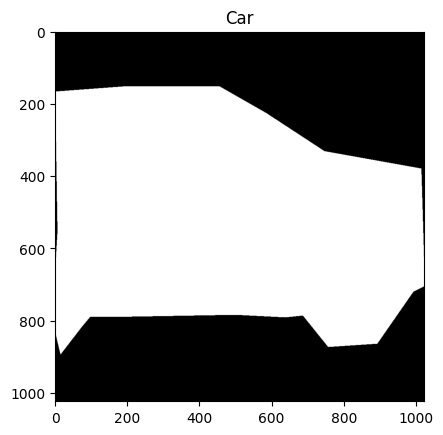

In [254]:
plt.title(target_labels['IMG_8432.JPG'])
plt.imshow(masked_images['IMG_8432.JPG'])

##DataLoader

In [255]:
n_classes = 2
BATCH_SIZE = 2
TRAIN_SPLIT = 0.75
VAL_SPLIT = 0.125

In [256]:
transform = transforms.Compose([
    # transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [257]:
len(list(os.listdir(root_dir)))

112

In [258]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, root, img_names, masks, labels, bboxes, transforms):
    self.root = root
    self.masks = masks
    self.labels = labels
    self.bboxes = bboxes
    self.transforms = transforms
    self.imgs = img_names
    # self.imgs = list(os.listdir(root))
    self.img_names = img_names
    # print(self.imgs)
  
  def __getitem__(self,idx):
    img_path = os.path.join(self.root,self.img_names[idx])

    img = Image.open(img_path).convert("RGB")
    name = self.img_names[idx]
    mask = self.masks[name].convert("RGB")
    #plt.imshow(mask)
    rboxes = [self.bboxes[name]]
    # ms = mask
    # ms = ms.convert('L')

    if self.transforms:
      img = self.transforms(img)
      mask = self.transforms(mask)    

    label = self.labels[name]
    classes = [1] if label == 'Car' else [0]
    
    #rboxes = torch.as_tensor(rboxes, dtype=torch.float32)
    #mask = torch.as_tensor(mask, dtype=torch.uint8)


    target = {
            'boxes': torch.as_tensor(rboxes, dtype=torch.float32),
            'labels': torch.as_tensor(classes, dtype=torch.int64),
            'masks': mask
            }
    return img, target

  def __len__(self):
    return len(self.imgs)



In [259]:
custom_data = CustomDataset(root=root_dir,img_names=common_image, masks=masked_images,labels=target_labels,bboxes=bboxes, transforms=transform)

indices = list(range(len(custom_data)))
s1 = int(np.floor(TRAIN_SPLIT * len(custom_data)))
s2 = int((len(custom_data) - s1)/2)

# s2 = int(np.floor(VAL_SPLIT*len(custom_data)))

train_indx = indices[:s1]
val_indx = indices[s1:s1+s2]
test_index = indices[s1+s2:]

train_sampler = SubsetRandomSampler(train_indx)
val_sampler = SubsetRandomSampler(val_indx)
test_sampler = SubsetRandomSampler(test_index)

train_data = DataLoader(custom_data, batch_size = BATCH_SIZE, sampler=train_sampler, shuffle=False,collate_fn=lambda x:list(zip(*x)))
val_data = DataLoader(custom_data, batch_size = BATCH_SIZE, sampler=val_sampler, shuffle=False,collate_fn=lambda x:list(zip(*x)))
test_data = DataLoader(custom_data, batch_size = BATCH_SIZE, sampler=test_sampler, shuffle=False,collate_fn=lambda x:list(zip(*x)))

In [260]:
print(train_indx)
print(val_indx)
print(test_index)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]
[79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]
[92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105]


## Visulaisations

In [261]:
print(len(custom_data))
print(len(train_data))
print(len(val_data))
print(len(test_data))


106
40
7
7


In [262]:
for i,(img, tgt) in enumerate(train_data):
  print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [263]:
t_i = []
t_m = []
t_l = []
for i, (imgs, targets) in enumerate(train_data):
    t = transforms.ToPILImage()
    img = t(imgs[0])
    msk = t(targets[0]['masks'])
    #plt.imshow(msk)
    t_i.append(img)
    t_m.append(msk)
    t_l.append(targets[0]['labels'])

In [264]:
ims,_ = next(iter(train_data))
print(ims[0].shape)

torch.Size([3, 1024, 1024])


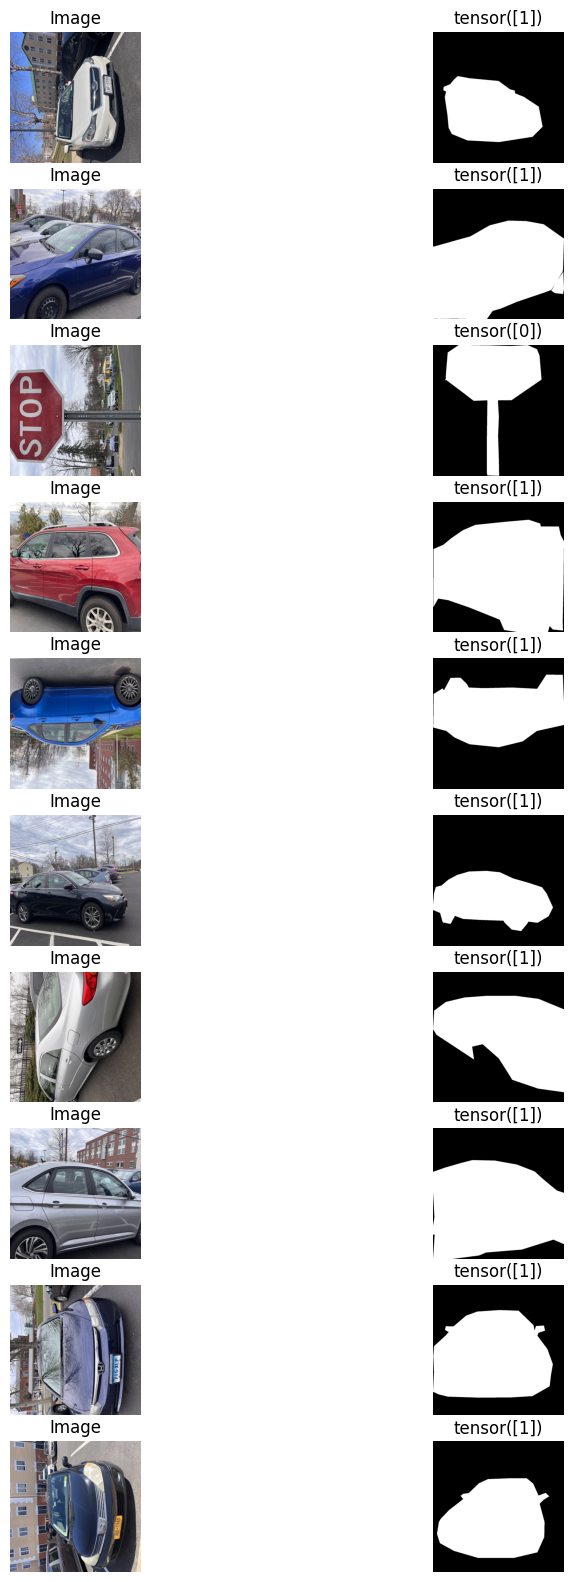

In [265]:
import matplotlib.pyplot as plt

# assuming you have two lists: images and masks
num_images = len(t_i)
n = int(num_images / 4)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(10, 20))

for i in range(n):
    # display the image in the left subplot
    axes[i, 0].imshow(t_i[i])
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')
    
    # display the mask in the right subplot
    axes[i, 1].imshow(t_m[i])
    axes[i, 1].set_title(f'{t_l[i]}')
    axes[i, 1].axis('off')

plt.show()


In [266]:
vim,vtrg = next(iter(val_data))

print(vtrg)

({'boxes': tensor([[ 65., 410., 854., 923.]]), 'labels': tensor([1]), 'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])}, {'boxes': tensor([[ 137.,  384., 1024.,  655.]]), 'labels': tensor([0]), 'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [

## Model Training


In [268]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import torch.nn as nn
class MiniNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
        # backbone network
        self.backbone = models.resnet18(pretrained=True)
        
        # Feature Pyramid Network (FPN)
        self.fpn = models.detection.FPN([64, 128, 256, 512], 256)
        
        # region proposal network (RPN)
        self.rpn = models.detection.rpn.AnchorGenerator(
            sizes=((32, 64, 128, 256, 512),),
            aspect_ratios=((0.5, 1.0, 2.0),)
        )
        
        # ROI align pooling
        self.roi_pool = models.detection.roi_heads.RoIAlign(output_size=(7, 7), sampling_ratio=2)
        
        # box and mask heads
        self.box_head = nn.Sequential(
            nn.Linear(256 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True)
        )
        
        self.box_predictor = nn.Sequential(
            nn.Linear(1024, num_classes * 4)
        )
        
        self.mask_head = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.mask_predictor = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, num_classes, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
              # initialize conv3 layers in the backbone with kaiming_normal initialization
        for layer in self.backbone.layer3:
            if isinstance(layer, nn.Conv2d):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)
    def forward(self, images, targets):
        # backbone features
        features = self.backbone(images)
        
        # FPN features
        features = self.fpn(features)
        
        # RPN proposals
        proposals = self.rpn(features)
        
        # ROI pooled features
        box_features = self.roi_pool(features, proposals)
        mask_features = self.roi_pool(features, proposals)
        
        # box and mask heads
        box_features = self.box_head(box_features.flatten(start_dim=1))
        class_logits = self.box_predictor(box_features).view(-1, self.num_classes, 4)
        
        mask_features = self.mask_head(mask_features)
        mask_logits = self.mask_predictor(mask_features)
        
        # output dictionary
        output = {
            "loss_box_reg": class_logits,
            "loss_mask": mask_logits
        }
        
        # calculate and return the loss
        losses = sum(loss for loss in output.values())
        return losses


In [269]:
model = MiniNet(n_classes)

In [270]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00001, momentum=0.9, weight_decay=0.0005)

In [272]:
from tqdm.notebook import tqdm
# Perform training loop for n epochs
loss_list = []
vloss_list = []
n_epochs = 10
model.train()
for epoch in tqdm(range(n_epochs)):
    loss_epoch = []
    vloss_epoch = []
    for images,targets in tqdm(train_data):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        model=model.float()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()       
        optimizer.step()
        # print('loss:', losses.item())
        # loss_epoch.append(losses.item())
        loss_epoch.append(losses.item())
    
    with torch.no_grad():
      val_loss = 0.0
      for imgs, trgts in tqdm(val_data):
        imgs = list(image.to(device) for image in imgs)
        trgts = [{k: v.to(device) for k, v in t.items()} for t in trgts]

        vloss_dict = model(imgs, trgts)
        vloss = sum(vl for vl in vloss_dict.values())
        vloss = vloss.cpu().data.numpy()
        vloss_epoch.append(vloss)
        
    torch.cuda.empty_cache()
    loss_epoch_mean = np.mean(loss_epoch) 
    loss_list.append(loss_epoch_mean)

    vloss_epoch_mean = np.mean(vloss_epoch)
    vloss_list.append(vloss_epoch_mean)
    print(f"The mean training loss for {epoch}th epoch: {loss_epoch_mean}") 
    # loss_list.append(loss_epoch_mean)    
    print(f"The mean validation loss for {epoch}th epoch: {vloss_epoch_mean}") 



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

The mean training loss for 0th epoch: 1.134958876669407
The mean validation loss for 0th epoch: 0.8730342984199524


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

The mean training loss for 1th epoch: 1.0438761733472348
The mean validation loss for 1th epoch: 0.8652266263961792


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

The mean training loss for 2th epoch: 0.9192004881799221
The mean validation loss for 2th epoch: 0.8313143849372864


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

The mean training loss for 3th epoch: 0.8923438876867295
The mean validation loss for 3th epoch: 0.7958404421806335


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

The mean training loss for 4th epoch: 0.8750082608312368
The mean validation loss for 4th epoch: 0.7089700698852539


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

The mean training loss for 5th epoch: 0.8025063719600439
The mean validation loss for 5th epoch: 0.7351082563400269


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

The mean training loss for 6th epoch: 0.8215677201747894
The mean validation loss for 6th epoch: 0.7876760363578796


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

The mean training loss for 7th epoch: 0.7688359312713147
The mean validation loss for 7th epoch: 0.6837697625160217


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

The mean training loss for 8th epoch: 0.7692149542272091
The mean validation loss for 8th epoch: 0.6593252420425415


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

The mean training loss for 9th epoch: 0.7242904022336006
The mean validation loss for 9th epoch: 0.6108287572860718


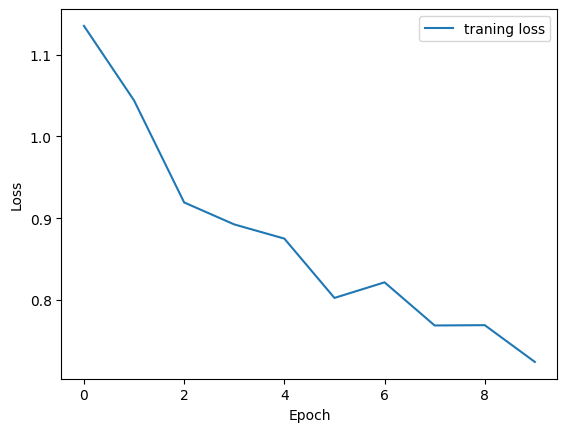

In [273]:
# Plot training loss
plt.plot(list(range(n_epochs)), loss_list, label='traning loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

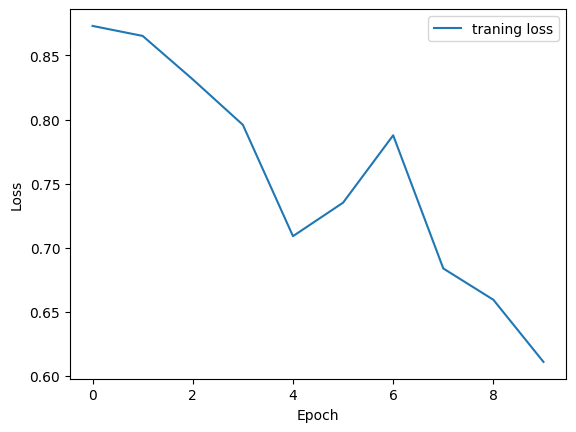

In [274]:
# Plot Validation loss
plt.plot(list(range(n_epochs)), vloss_list, label='traning loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [275]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

In [276]:
model = torch.jit.load('model_scripted.pt')
model.eval()

RecursiveScriptModule(
  original_name=MaskRCNN
  (transform): RecursiveScriptModule(original_name=GeneralizedRCNNTransform)
  (backbone): RecursiveScriptModule(
    original_name=BackboneWithFPN
    (body): RecursiveScriptModule(
      original_name=IntermediateLayerGetter
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
      (layer1): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=Bottleneck
          (conv1): RecursiveScriptModule(original_name=Conv2d)
          (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
          (conv2): RecursiveScriptModule(original_name=Conv2d)
          (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
          (conv3): RecursiveScriptModule(original_name=Conv2d)
          (bn3): Rec

## Evaluate

In [282]:
o_i = []
for i, (img,trt) in enumerate(test_data):
  for j in range(BATCH_SIZE):
    o_i.append(img[j])

In [283]:
len(o_i)

14

In [284]:
len(model_output)

6

In [285]:
ct_i = []
ct_m = []
ct_l = []
for i, (imgs, targets) in enumerate(test_data):
    t = transforms.ToPILImage()
    img = t(imgs[0])
    msk = t(targets[0]['masks'])
    #plt.imshow(msk)
    ct_i.append(img)
    ct_m.append(msk)
    ct_l.append(targets[0]['labels'])

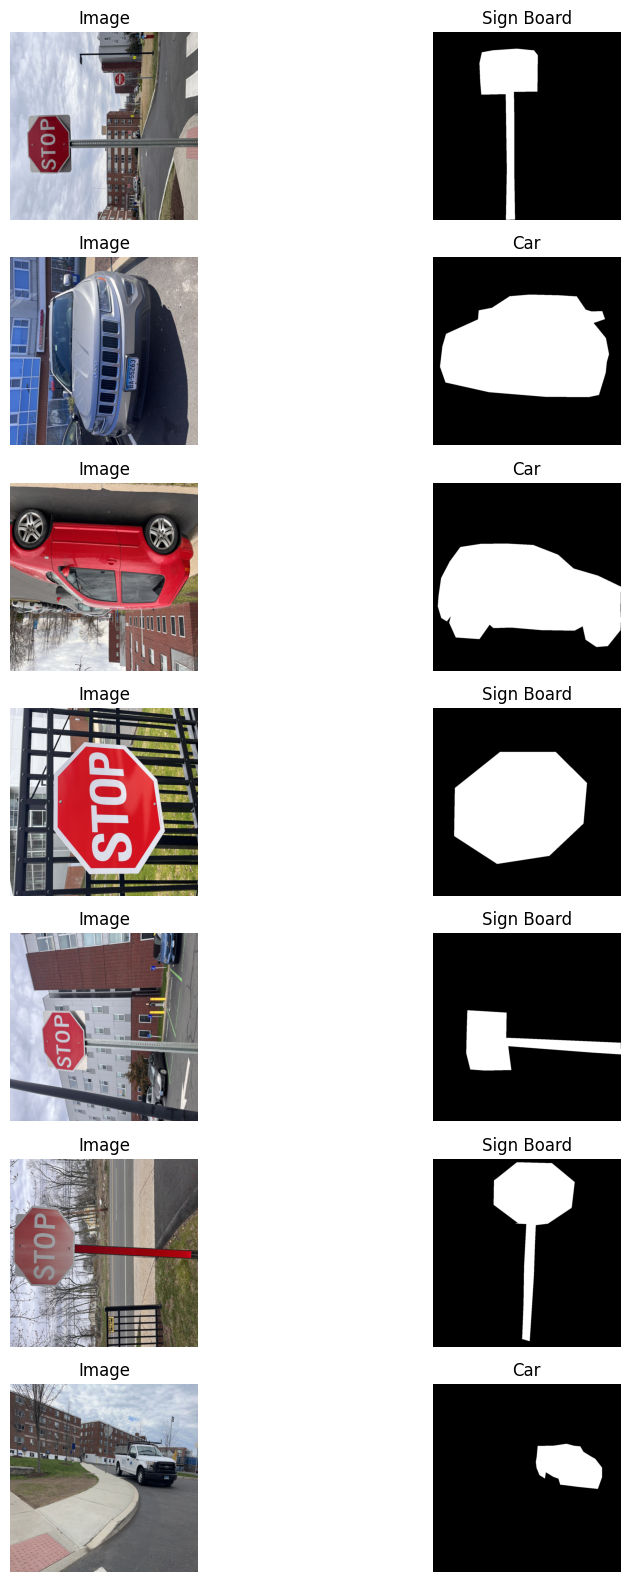

In [286]:
import matplotlib.pyplot as plt

# assuming you have two lists: images and masks
num_images = len(ct_i)

fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 20))

for i in range(num_images):
    # display the image in the left subplot
    axes[i, 0].imshow(ct_i[i])
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')
    
    # display the mask in the right subplot
    if ct_l[i] == 1:
      title = 'Car'
    else:
      title = 'Sign Board'
    axes[i, 1].imshow(ct_m[i])
    axes[i, 1].set_title(f'{title}')
    axes[i, 1].axis('off')

plt.show()


In [287]:
image_tensor = model_output[1][1].get('masks')[0]

In [288]:
image_tensor *= 255

In [289]:
image_tensor

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')